# **GenoVarDis@IberLEF2024: Automatic Genomic Variants and Related Diseases using Named Entity Recognition with Large Language Models**

## Autor: Víctor Manuel Oliveros Villena


In [ ]:
# Esta es la ruta a la raíz de nuestro Drive.
# Si se prefiere otra ruta, añadir los directorios pertinentes a continuación de esta.
path_drive = '/content/drive/MyDrive'

### **Configuración del entorno**

In [ ]:
!pip install gliner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusp

In [ ]:
import numpy as np
import torch
import os
from google.colab import drive
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from gliner import GLiNER

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### **Lectura de los archivos**

In [ ]:
# Ruta al archivo TSV en Google Drive
path_test_text = path_drive + '/GenoVarDis/Data/test_text.tsv'
path_test_annotation = path_drive + '/GenoVarDis/Data/test_annotation.tsv'

# Leer el archivo TSV utilizando pandas
test_text = pd.read_csv(path_test_text, sep='\t')
test_annotation = pd.read_csv(path_test_annotation, sep='\t')

# Eliminacion de la columna mark, pues nos es irrelevante
test_annotation = test_annotation.drop('mark', axis=1)

# Ruta al archivo TSV en Google Drive
path_dev_text = path_drive + '/GenoVarDis/Data/dev_text.tsv'
path_dev_annotation = path_drive + '/GenoVarDis/Data/dev_annotation.tsv'

# Leer el archivo TSV utilizando pandas
dev_text = pd.read_csv(path_dev_text, sep='\t')
dev_annotation = pd.read_csv(path_dev_annotation, sep='\t')

# Eliminacion de la columna mark, pues nos es irrelevante
dev_annotation = dev_annotation.drop('mark', axis=1)

### **Estructura de las predicciones realizadas por nuestro modelo Fine-tuned GLiNER**

In [ ]:
# Carga del modelo
# Por defecto, se ha cargado el modelo GLiNERMedium_Trainer
# Las demas opciones son:
#   - GLiNERMedium_DevTest
#   - GLiNERMedium_DevVal
#   - GLiNERSmall_DevTest
my_model = GLiNER.from_pretrained(path_drive + "/GenoVarDis/Logs/GLiNERMedium_Trainer", local_files_only=True)

config.json not found in /content/drive/MyDrive/TFG_VictorOliverosVillena/Logs/GLiNERMedium_Trainer
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Caso clinico de ejemplo
example = dev_text.iloc[0]['text']
# Tipos de entidades
labels = ["Gene", "Disease", "DNAMutation", "SNP", "DNAAllele", "NucleotideChange-BaseChange", "OtherMutation", "Transcript"]
# Predicciones de nuestro modelo
pred_ex = my_model.predict_entities(example, labels, threshold=0.5)

pred_ex

[{'start': 11,
  'end': 35,
  'text': 'Deficiencia total de C4B',
  'label': 'Disease',
  'score': 0.8112531304359436},
 {'start': 99,
  'end': 117,
  'text': 'infecciones graves',
  'label': 'Disease',
  'score': 0.5615259408950806},
 {'start': 307,
  'end': 318,
  'text': 'infecciones',
  'label': 'Disease',
  'score': 0.5211927890777588},
 {'start': 359,
  'end': 383,
  'text': 'deficiencia total de C4B',
  'label': 'Disease',
  'score': 0.805009663105011},
 {'start': 413,
  'end': 434,
  'text': 'meningitis recurrente',
  'label': 'Disease',
  'score': 0.6465089917182922},
 {'start': 436,
  'end': 453,
  'text': 'fístulas crónicas',
  'label': 'Disease',
  'score': 0.9591810703277588},
 {'start': 456,
  'end': 464,
  'text': 'abscesos',
  'label': 'Disease',
  'score': 0.9810266494750977},
 {'start': 546,
  'end': 549,
  'text': 'C4B',
  'label': 'Gene',
  'score': 0.9981915354728699},
 {'start': 588,
  'end': 591,
  'text': 'C4B',
  'label': 'Gene',
  'score': 0.9884145259857178},

### **Generación del archivo TSV a partir de Fine-tuned GLiNER**

In [ ]:
# Ruta donde guardar el archivo generado
filename = path_drive + '/GenoVarDis/EvaluationTSV/annotation_GLiNERMedium_Trainer.tsv'
# Tipos de entidades
labels = ["Gene", "Disease", "DNAMutation", "SNP", "DNAAllele", "NucleotideChange-BaseChange", "OtherMutation", "Transcript"]
# Etiquetas de las columnas del TSV
tags = 'pmid\tfilename\tlabel\toffset1\toffset2\tspan\n'

with open(filename, 'w') as file:
  # Escribimos las etiquetas de las columnas en el archivo
  file.write(tags)
  # Por cada caso clinico...
  # Al usar dev como validación, usamos test_text como test.
  # Para usar dev como test, cambiar test_text.iterrows() por dev_text.iterrows()
  for i, row in test_text.iterrows():
    text = row['text']        # Obtencion del texto del caso clinico
    pmid = row['pmid']        # Obtencion del pmid
    ann = f"pmid-{pmid}.ann"  # Obtenicion del archivo ann
    offset1 = 0
    offset2 = 0

    # Obtencion de las predicciones de nuestro modelo
    entities = my_model.predict_entities(text, labels, threshold=0.5)

    # Por cada entidad detectada
    for entity in entities:
      label = entity['label']               # Tipo de entidad
      span = entity['text']                 # Entidad detectada
      pattern = rf'\b{re.escape(span)}\b'   # Patron de busqueda de la entidad
      matches = re.finditer(pattern, text)  # Iterador con todas las coincidencias
      # Por cada coincidencia
      for m in matches:
        # Guardar aquella posicion de inicio y fin que sea valida
        if m.start() > offset2:
          offset1 = m.start()
          offset2 = m.end()
          break
      # Añadir la entidad al archivo TSV
      file.write(f"{pmid}\t{ann}\t{label}\t{offset1}\t{offset2}\t{span}\n")

# **Análisis de GLiNER**

## **GLiNER Small con Dev_text como test**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_GLiNERSmall_DevTest.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Evolución de las métricas durante cada época del entrenamiento*

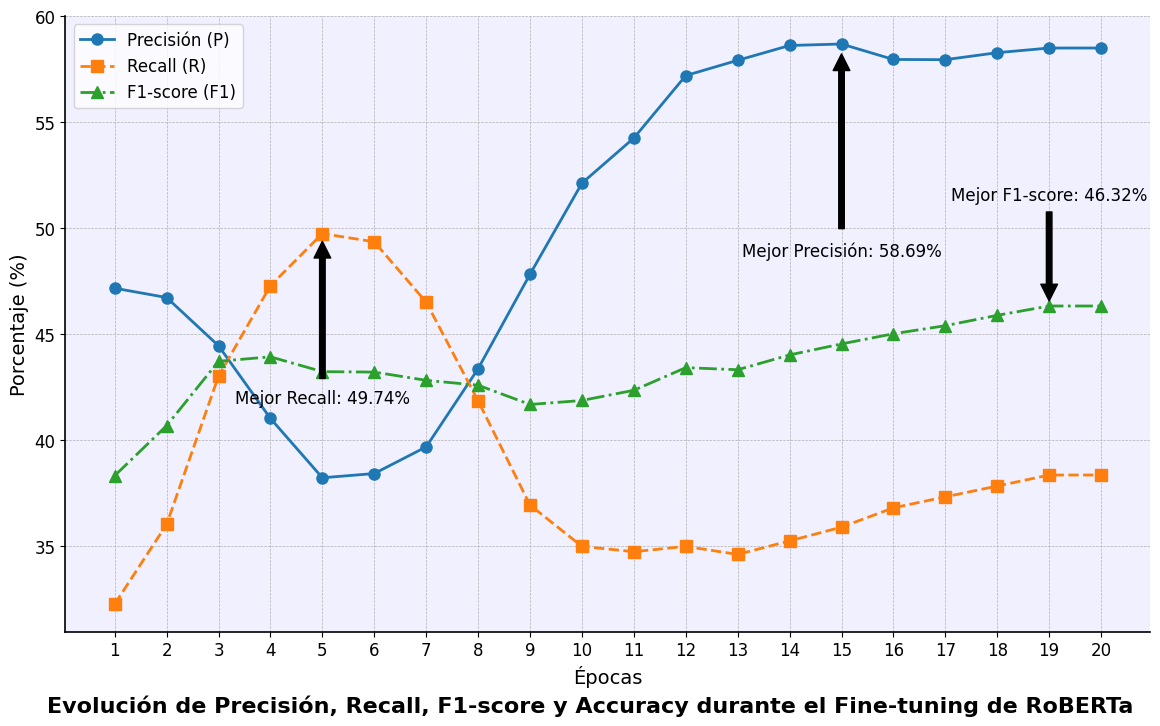

In [ ]:
# Metricas obtenidas durante el entrenamiento
precision = [47.16, 46.72, 44.44, 41.01, 38.21, 38.41, 39.67, 43.36, 47.82, 52.12, 54.25, 57.20, 57.92, 58.62, 58.69, 57.96, 57.95, 58.28, 58.50, 58.50]
recall = [32.25, 36.01, 43.01, 47.28, 49.74, 49.35, 46.50, 41.84, 36.92, 34.97, 34.72, 34.97, 34.59, 35.23, 35.88, 36.79, 37.31, 37.82, 38.34, 38.34]
f1_score = [38.31, 40.67, 43.71, 43.92, 43.22, 43.20, 42.81, 42.58, 41.67, 41.86, 42.34, 43.41, 43.31, 44.01, 44.53, 45.01, 45.39, 45.88, 46.32, 46.32]

# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precisión (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Porcentaje (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Mejor Precisión: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 10),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) - 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) + 5),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
            wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Curvas de aprendizaje*

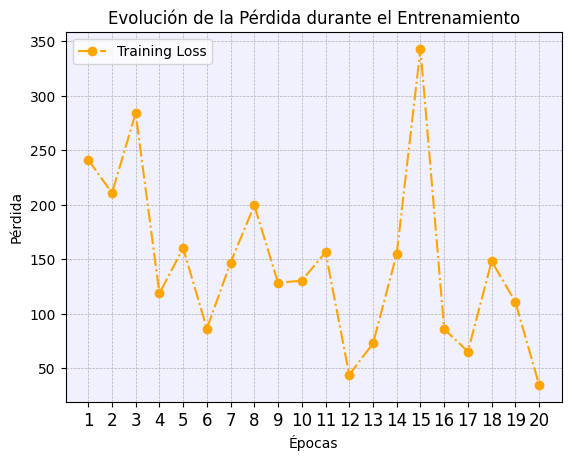

In [ ]:
# Pérdidas obtenidas durante el entrenamiento
loss_values = [241.65, 210.94, 284.08, 118.82, 160.32, 86.48, 147.15, 199.67, 128.56, 130.57, 156.60, 44.24, 72.90, 155.00, 343.12, 86.14, 65.51, 148.36, 110.99, 34.88]

# Crear rango de épocas
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, color='orange', marker='o', linestyle='-.', label='Training Loss')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(epochs, fontsize=12)
plt.gca().set_facecolor('#f0f0ff')
plt.show()

### *Gráfica de frecuencias*

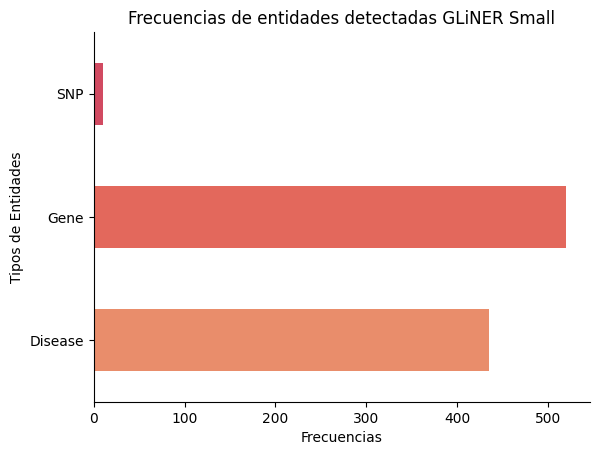

In [ ]:
# Frecuencias de las entidades predichas por el modelo
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas GLiNER Small')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Frecuencias concretas predichas por el modelo
frecuencia_labels = test_pred['label'].value_counts()
print(frecuencia_labels)

label
Gene       520
Disease    435
SNP         10
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, dev_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 965
Falsos positivos: 368 (38.13%)
Entidades detectadas correctamente: 597
Entidades detectadas y clasificadas correctamente: 567 (58.76% de las predicciones)



### *Matriz de confusión*

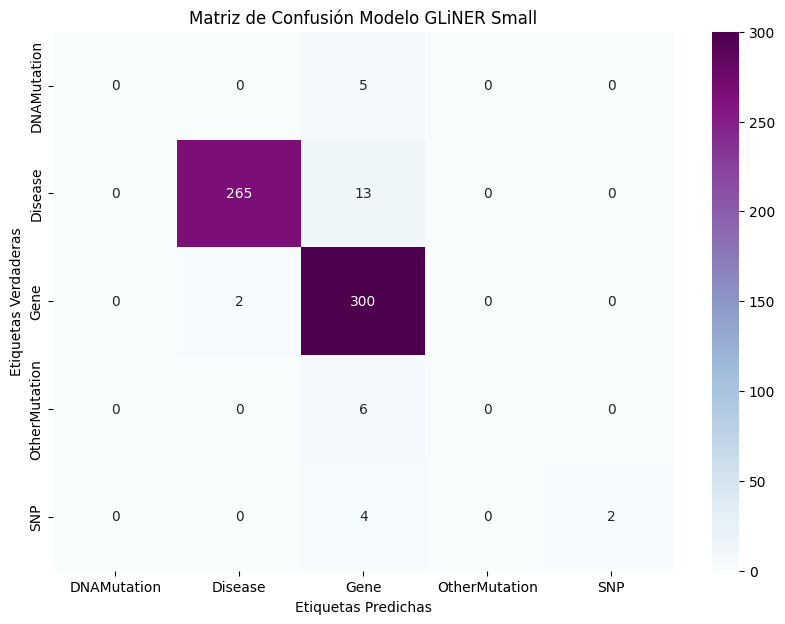

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo GLiNER Small')
plt.show()

### *Gráfica de distribución*

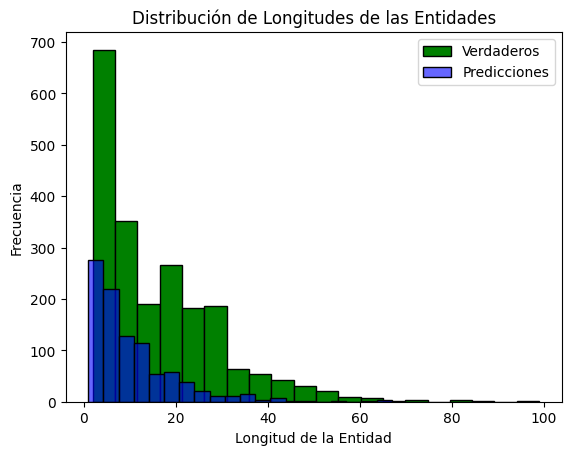

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(test_annotation['offset2'] - test_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()

## **GLiNER Medium con Dev_text como test**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_GLiNERMedium_DevTest.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Evolución de las métricas durante cada época del entrenamiento*

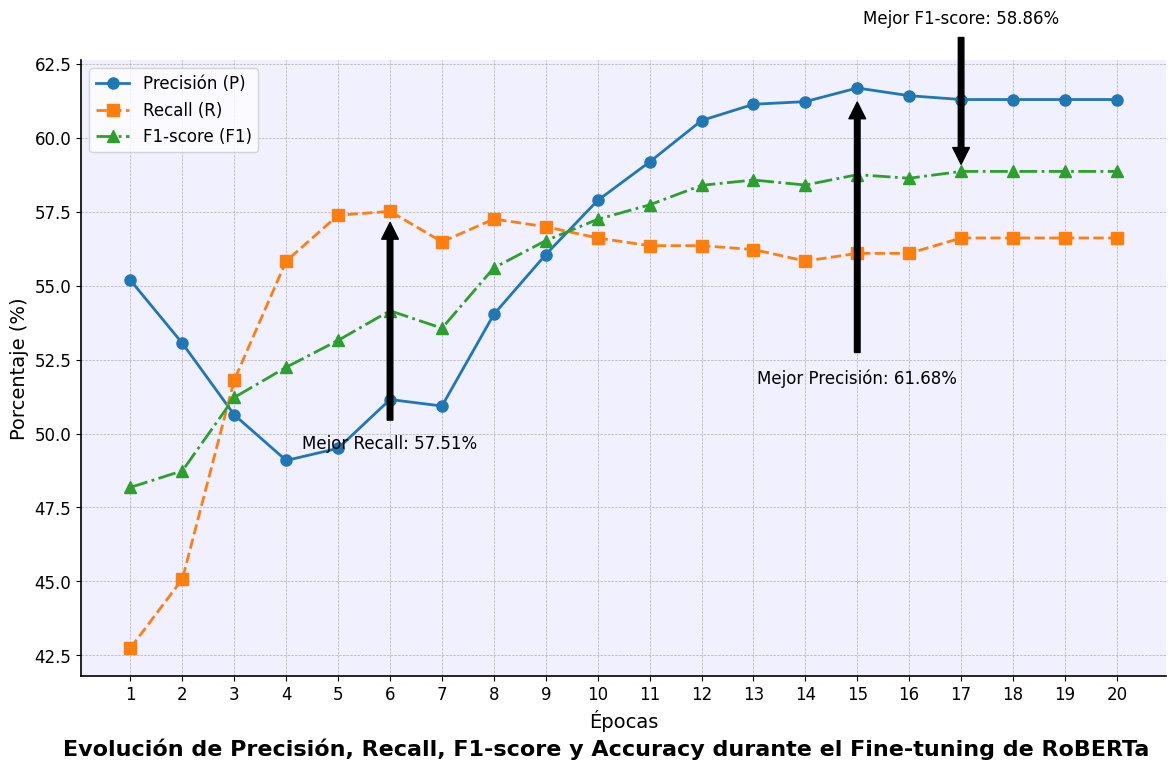

In [ ]:
precision = [55.18, 53.05, 50.63, 49.09, 49.50, 51.15, 50.93, 54.03, 56.05, 57.88, 59.18, 60.58, 61.13, 61.22, 61.68, 61.42, 61.29, 61.29, 61.29, 61.29]
recall = [42.75, 45.08, 51.81, 55.83, 57.38, 57.51, 56.48, 57.25, 56.99, 56.61, 56.35, 56.35, 56.22, 55.83, 56.09, 56.09, 56.61, 56.61, 56.61, 56.61]
f1_score = [48.18, 48.74, 51.22, 52.24, 53.15, 54.15, 53.56, 55.60, 56.52, 57.24, 57.73, 58.39, 58.57, 58.40, 58.75, 58.63, 58.86, 58.86, 58.86, 58.86]

# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precisión (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Porcentaje (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Mejor Precisión: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 10),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) - 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) + 5),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
            wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Curvas de aprendizaje*

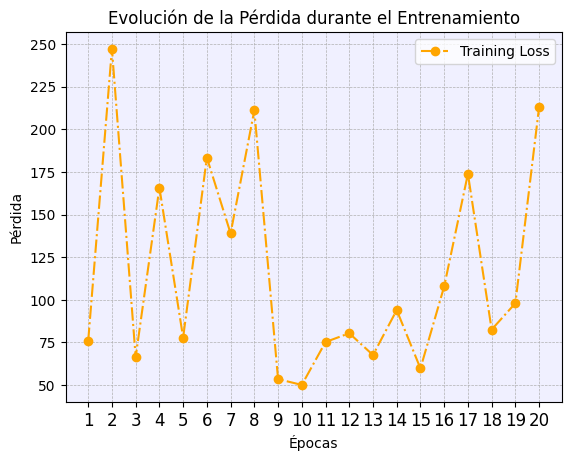

In [ ]:
loss_values = [75.93, 247.08, 66.39, 165.75, 77.87, 183.35, 138.93, 211.08, 53.52, 50.11, 75.25, 80.41, 67.62, 93.97, 59.78, 107.86, 173.86, 82.55, 98.00, 213.05]

# Crear rango de épocas
epochs = range(1, len(loss_values) + 1)

# Graficar la pérdida
plt.plot(epochs, loss_values, color='orange', marker='o', linestyle='-.', label='Training Loss')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(epochs, fontsize=12)
plt.gca().set_facecolor('#f0f0ff')
plt.show()

### *Gráficas de frecuencias*

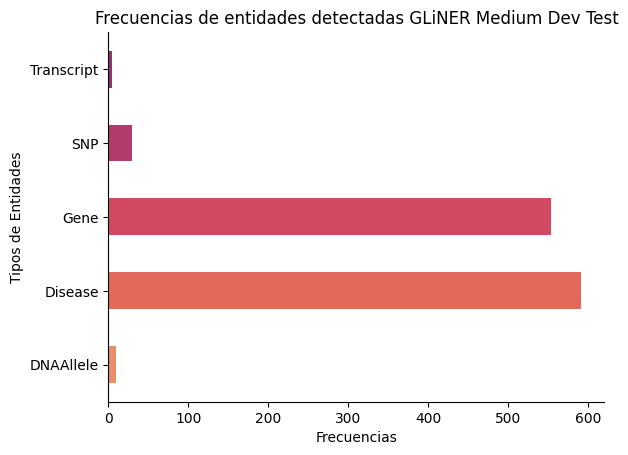

In [ ]:
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas GLiNER Medium Dev Test')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
frecuencia_labels = test_pred['label'].value_counts()

print(frecuencia_labels)

label
Disease       591
Gene          554
SNP            30
DNAAllele       9
Transcript      4
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, dev_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 1188
Falsos positivos: 326 (27.44%)
Entidades detectadas correctamente: 862
Entidades detectadas y clasificadas correctamente: 836 (70.37% de las predicciones)



### *Matriz de confusión*

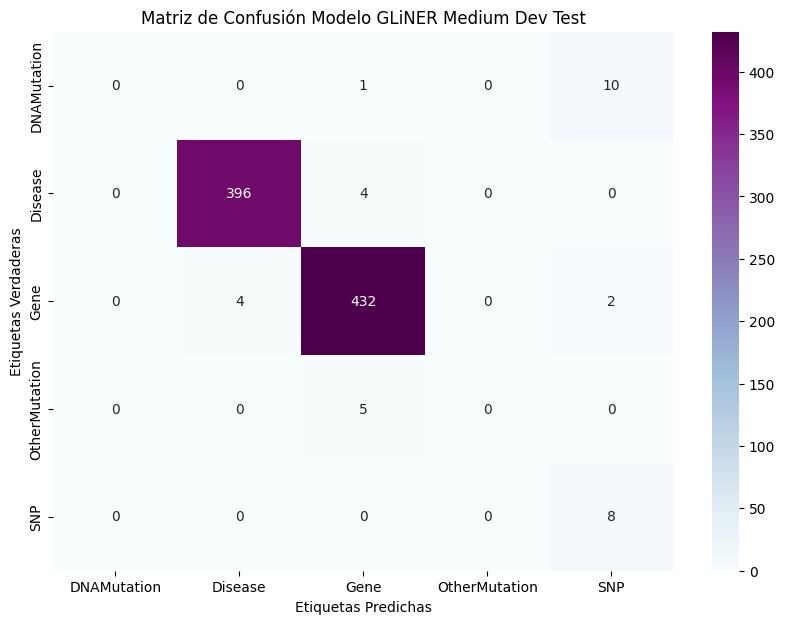

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo GLiNER Medium Dev Test')
plt.show()

### *Gráficas de distribución*

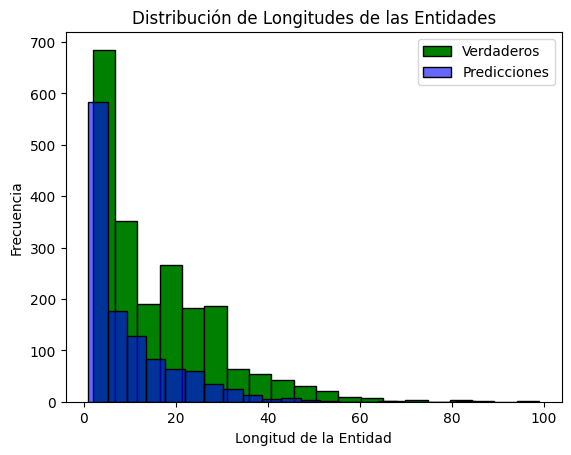

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(test_annotation['offset2'] - test_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()

## **GLiNER Medium con Dev_text como validación**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_GLiNERMedium_DevVal.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Evolución de las métricas durante cada época del entrenamiento*

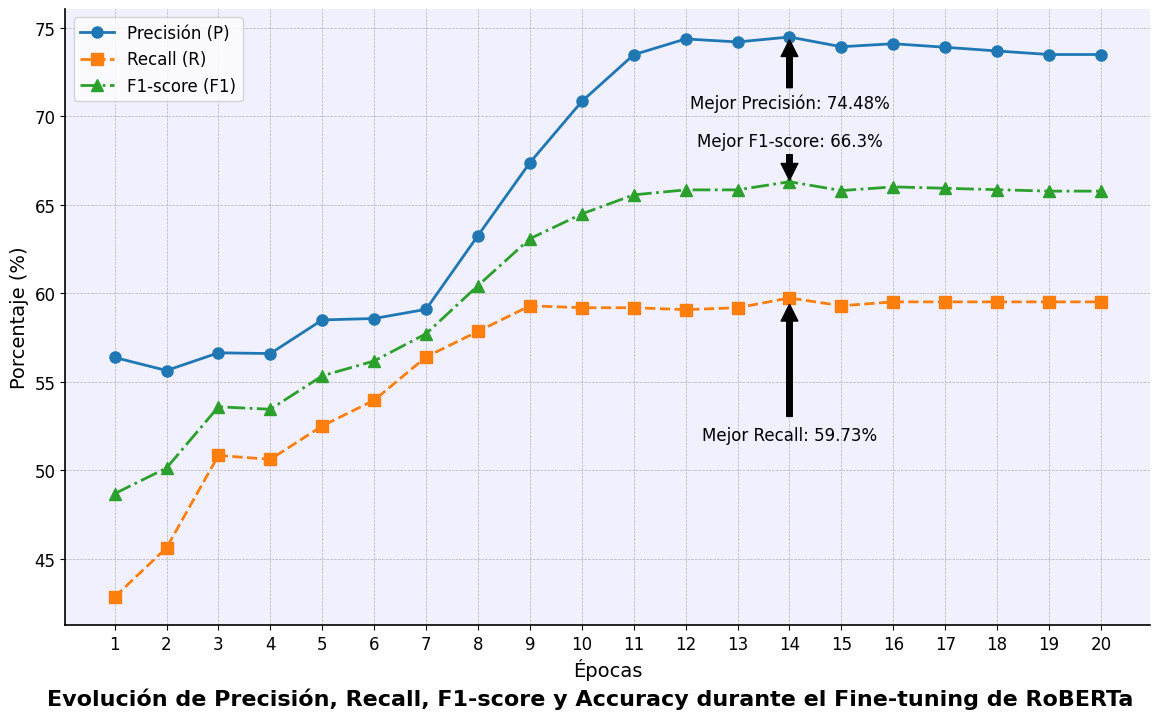

In [ ]:
precision = [56.37, 55.63, 56.63, 56.59, 58.49, 58.57, 59.09, 63.26, 67.38, 70.84, 73.48, 74.37, 74.20, 74.48, 73.93, 74.10, 73.90, 73.69, 73.49, 73.49]
recall = [42.83, 45.61, 50.83, 50.61, 52.50, 53.95, 56.40, 57.84, 59.29, 59.18, 59.18, 59.07, 59.18, 59.73, 59.29, 59.51, 59.51, 59.51, 59.51, 59.51]
f1_score = [48.67, 50.12, 53.58, 53.44, 55.33, 56.17, 57.71, 60.43, 63.08, 64.48, 65.56, 65.84, 65.84, 66.30, 65.80, 66.01, 65.93, 65.85, 65.77, 65.77]

# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precisión (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)

plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Porcentaje (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Mejor Precisión: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 4),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) - 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Mejor F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) + 2),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
            wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Curvas de aprendizaje*

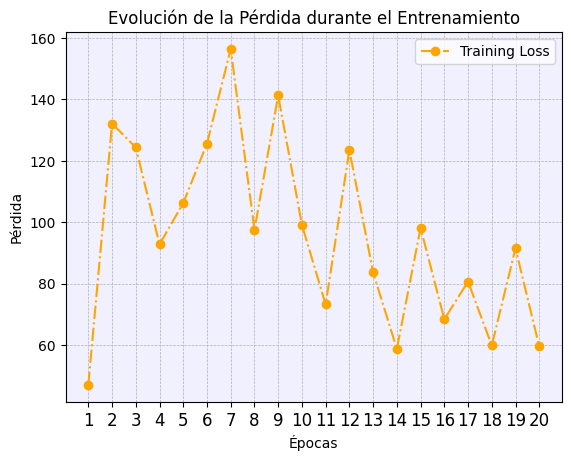

In [ ]:
loss_values = [47.03, 132.14, 124.34, 92.80, 106.25, 125.62, 156.42, 97.44, 141.27, 99.15, 73.22, 123.53, 83.66, 58.75, 98.15, 68.41, 80.67, 59.87, 91.52, 59.57]

# Crear rango de épocas
epochs = range(1, len(loss_values) + 1)

# Graficar la pérdida
plt.plot(epochs, loss_values, color='orange', marker='o', linestyle='-.', label='Training Loss')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(epochs, fontsize=12)
plt.gca().set_facecolor('#f0f0ff')
plt.show()

### *Gráficas de frecuencias*

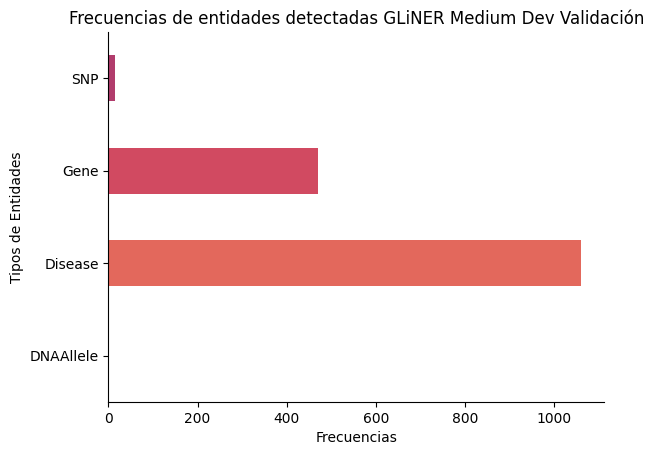

In [ ]:
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas GLiNER Medium Dev Validación')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
frecuencia_labels = test_pred['label'].value_counts()

print(frecuencia_labels)

label
Disease      1059
Gene          471
SNP            14
DNAAllele       2
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, test_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 1546
Falsos positivos: 263 (17.01%)
Entidades detectadas correctamente: 1283
Entidades detectadas y clasificadas correctamente: 1269 (82.08% de las predicciones)



### *Matriz de confusión*

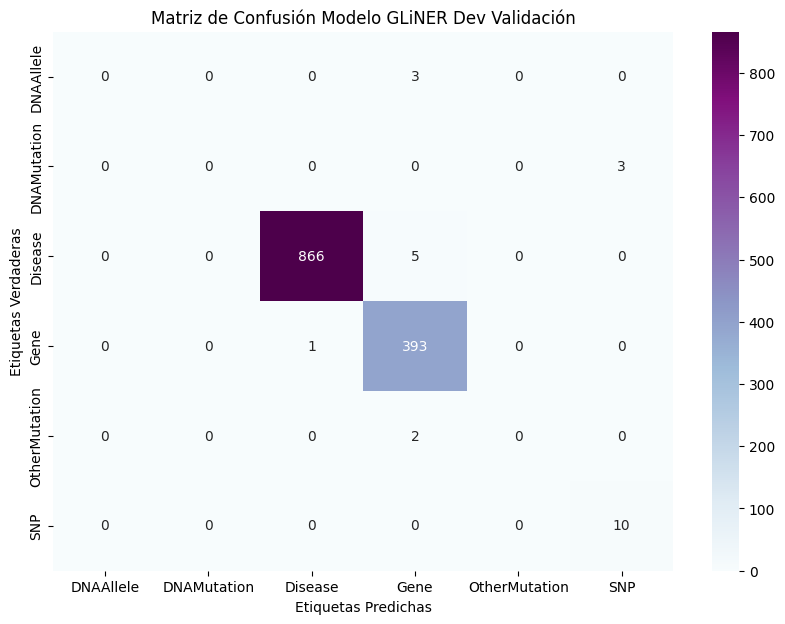

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo GLiNER Dev Validación')
plt.show()

### *Gráfica de distribución*

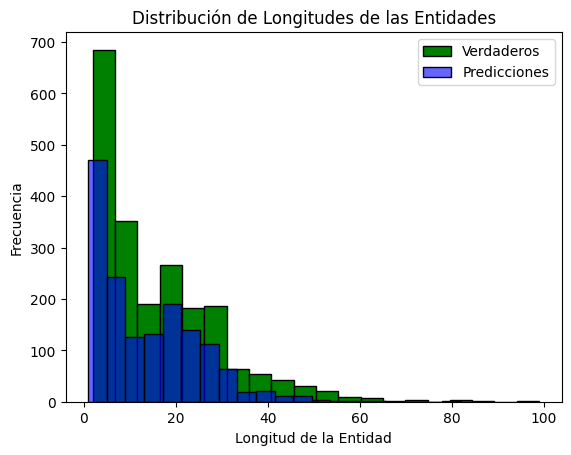

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(test_annotation['offset2'] - test_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()

## **GLiNER Medium con Dev_text como validación y Trainer.py**

In [ ]:
# Ruta al archivo TSV en tu Google Drive
path_test_pred = path_drive + '/GenoVarDis/EvaluationTSV/annotation_GLiNERMedium_Trainer.tsv'

# Leer el archivo TSV utilizando pandas
test_pred = pd.read_csv(path_test_pred, sep='\t')

### *Evolución de las métricas durante cada época del entrenamiento*

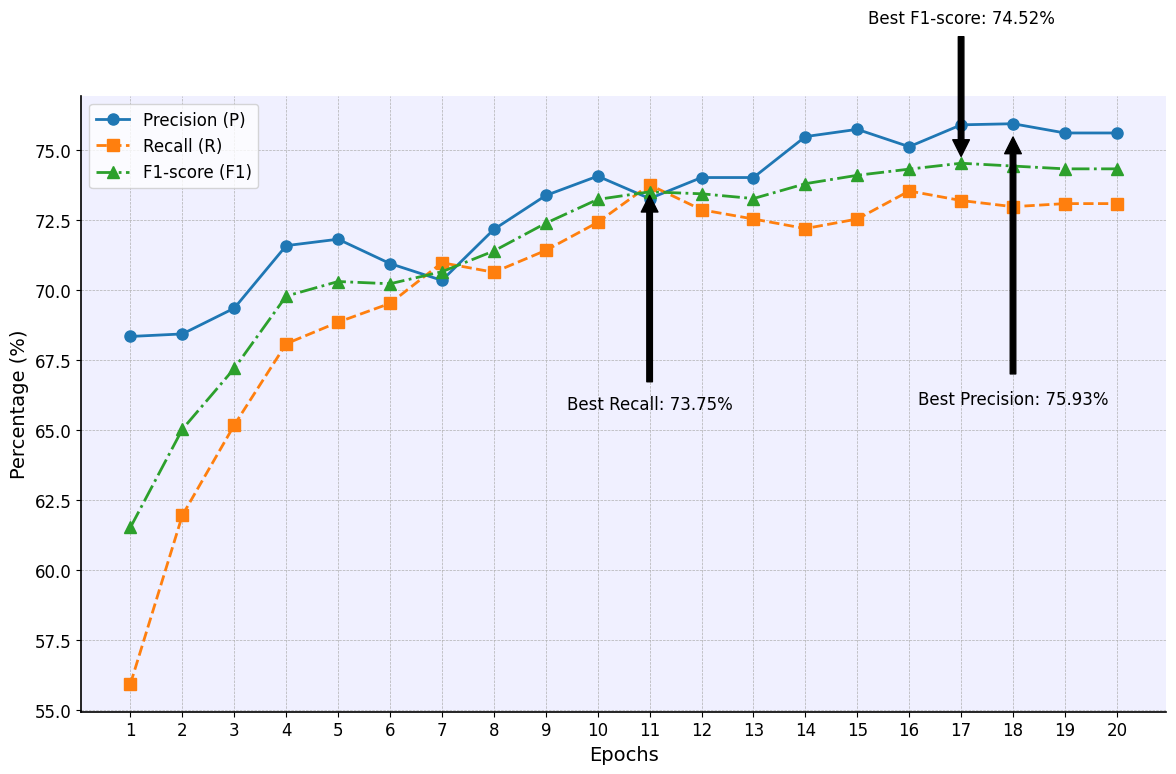

In [ ]:
precision = [68.34, 68.43, 69.35, 71.58, 71.81, 70.94, 70.34, 72.16, 73.37, 74.06, 73.26, 74.01, 74.01, 75.47, 75.73, 75.11, 75.89, 75.93, 75.60, 75.60]
recall = [55.95, 61.96, 65.18, 68.08, 68.85, 69.52, 70.97, 70.63, 71.41, 72.41, 73.75, 72.86, 72.53, 72.19, 72.53, 73.53, 73.19, 72.97, 73.08, 73.08]
f1_score = [61.53, 65.03, 67.20, 69.78, 70.30, 70.22, 70.65, 71.39, 72.38, 73.23, 73.50, 73.43, 73.26, 73.79, 74.09, 74.31, 74.52, 74.42, 74.32, 74.32]

# Crear el gráfico
epochs = range(1, 21)

# Crear el gráfico nuevamente con el título en la parte inferior
plt.figure(figsize=(14, 8))

plt.plot(epochs, precision, label='Precision (P)', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, recall, label='Recall (R)', marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, label='F1-score (F1)', marker='^', linestyle='-.', linewidth=2, markersize=8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar el aspecto del borde y la cuadrícula
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Añadir anotaciones para el mejor punto en cada métrica
best_precision_epoch = precision.index(max(precision)) + 1
best_recall_epoch = recall.index(max(recall)) + 1
best_f1_epoch = f1_score.index(max(f1_score)) + 1

plt.annotate(f'Best Precision: {max(precision)}%', xy=(best_precision_epoch, max(precision)),
             xytext=(best_precision_epoch, max(precision) - 10),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Best Recall: {max(recall)}%', xy=(best_recall_epoch, max(recall)),
             xytext=(best_recall_epoch, max(recall) - 8),  # Ajuste vertical aquí
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

plt.annotate(f'Best F1-score: {max(f1_score)}%', xy=(best_f1_epoch, max(f1_score)),
             xytext=(best_f1_epoch, max(f1_score) + 5),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, ha='center')

# Añadir el título en la parte inferior
# plt.figtext(0.5, 0.01, 'Evolución de Precisión, Recall, F1-score y Accuracy durante el Fine-tuning de RoBERTa',
#             wrap=True, horizontalalignment='center', fontsize=16, fontweight='bold')

plt.gca().set_facecolor('#f0f0ff')

# Mostrar el gráfico
plt.show()

### *Curvas de aprendizaje*

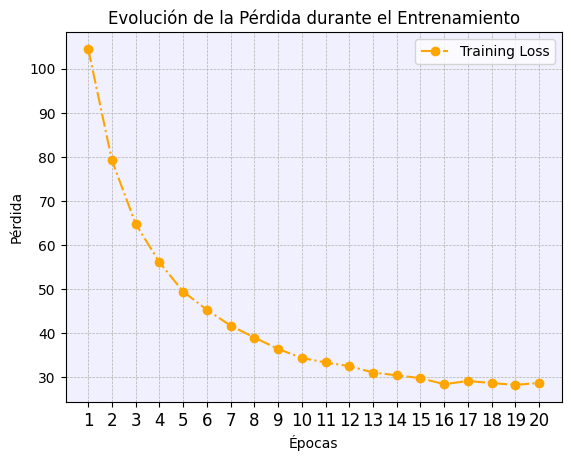

In [ ]:
loss_values = [104.48708699430738, 79.23309877940586, 64.8128315125193, 56.11617525134768, 49.48051529271262, 45.348886179072515, 41.7455664404801, 39.051191576889586, 36.47751698323658, 34.41301850335939, 33.40691359447582, 32.57487925887108, 31.12333712407521, 30.492397086960928, 29.841055738074438, 28.472298826490128, 29.196867606469564, 28.731610421623504, 28.307048923202924, 28.76741732444082]

# Crear rango de épocas
epochs = range(1, len(loss_values) + 1)

# Graficar la pérdida
plt.plot(epochs, loss_values, color='orange', marker='o', linestyle='-.', label='Training Loss')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(epochs, fontsize=12)
plt.gca().set_facecolor('#f0f0ff')
plt.show()


### *Gráfica de frecuencias*

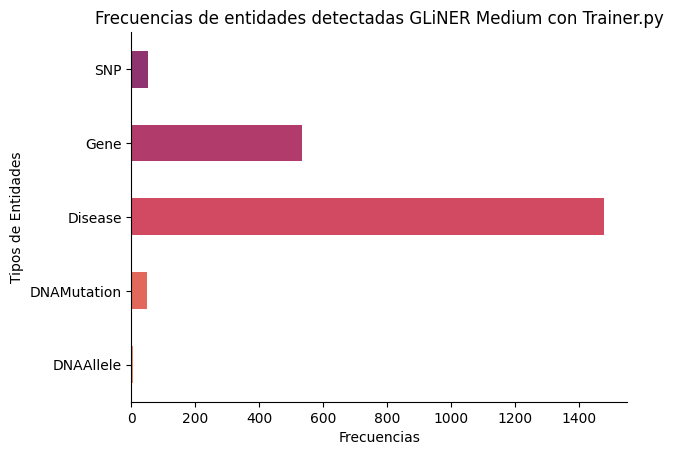

In [ ]:
test_pred.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('flare'))
plt.title('Frecuencias de entidades detectadas GLiNER Medium con Trainer.py')
plt.xlabel('Frecuencias')
plt.ylabel('Tipos de Entidades')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
frecuencia_labels = test_pred['label'].value_counts()

print(frecuencia_labels)

label
Disease        1479
Gene            533
SNP              52
DNAMutation      49
DNAAllele         5
Name: count, dtype: int64


### *Desglose de los resultados*

In [ ]:
# Combina los dataframes basándote en las columnas relevantes
merged_test = pd.merge(test_pred, test_annotation, on=['pmid', 'filename', 'offset1', 'offset2', 'span'], suffixes=('_pred', '_true'))
# Filtrar el DataFrame para incluir solo las filas donde label_pred y label_true coincidan
matching_test = merged_test[merged_test['label_pred'] == merged_test['label_true']]

# Extrae las etiquetas predichas y las verdaderas
y_pred = merged_test['label_pred']
y_true = merged_test['label_true']

len_merged = len(merged_test)
len_pred = len(test_pred)
len_matching = len(matching_test)
false_pos = len_pred - len_merged

# print(len(y_pred), len(y_true))
print(f"Predicciones realizadas: {len_pred}")
print(f"Falsos positivos: {false_pos} ({(false_pos * 100 / len_pred):.2f}%)")
print(f"Entidades detectadas correctamente: {len_merged}")
print(f"Entidades detectadas y clasificadas correctamente: {len_matching} ({(len_matching * 100 / len_pred):.2f}% de las predicciones)\n")

Predicciones realizadas: 2118
Falsos positivos: 426 (20.11%)
Entidades detectadas correctamente: 1692
Entidades detectadas y clasificadas correctamente: 1671 (78.90% de las predicciones)



### *Matriz de confusion*

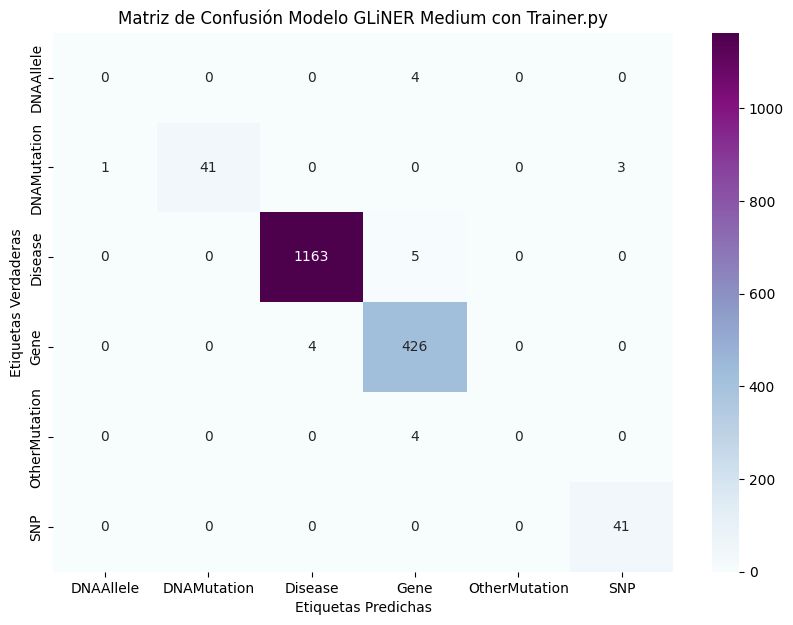

In [ ]:
# Genera la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Visualiza la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión Modelo GLiNER Medium con Trainer.py')
plt.show()

### *Gráfica de distribucion*

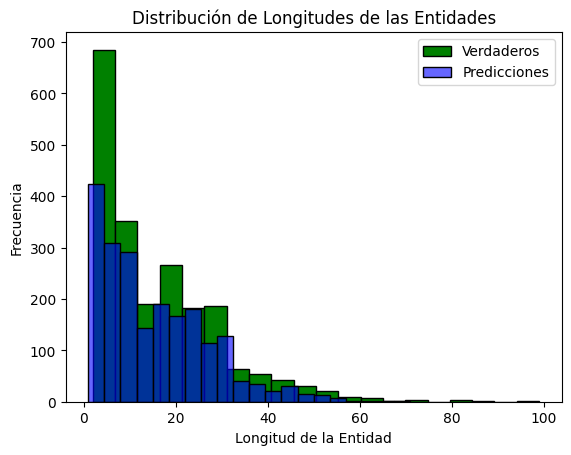

In [ ]:
# Histograma de las longitudes de las entidades verdaderas
sns.histplot(test_annotation['offset2'] - test_annotation['offset1'], bins=20, color='green', alpha=1, label='Verdaderos')
# Histograma de las longitudes de las entidades predichas
sns.histplot(test_pred['offset2'] - test_pred['offset1'], bins=20, color='blue', alpha=0.6, label='Predicciones')
plt.xlabel('Longitud de la Entidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de las Entidades')
plt.legend()
plt.show()
